<h1><center>Лабораторна робота 3.</center></h1>
<h2><center>Задача класифікації за набором даних Adult репозитарію UCI</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="3"></a>

## Зміст

1. [Синтетичний набір даних "дівчина в барі"](#3.1)
2. [Функції для обрахування ентропії й приросту інформації](#3.2)
3. [Задача класифікації за набором данних "Adult"](#3.3)
    - [Модель дерева рішень без налаштування параметрів](#3.3.1)
    - [Модель найближчих сусідів без налаштування параметрів](#3.3.2)
    - [Машинне моделювання з налаштуванням параметрів](#3.3.3)

У цій лабораторній роботі Вам пропонується розібратися з тим, як працює дерево рішень на іграшковому прикладі. Ми навчимо і налаштуємо дерево рішень і (за бажанням) випадковий ліс для задачі класифікації за уже знайомим набором даних Adult сховища UCI.

Спершу підключаємо необхідні бібліотеки:

In [1]:
# Відключимо різні попередження Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5
plt.gcf().set_dpi(100);

<Figure size 700x500 with 0 Axes>

<a class="anchor" id="3.1"></a>

## <span style="color:blue; font-size:1.2em;">3.1. Синтетичний набір даних "дівчина в барі"</span>

[Повернутися до змісту](#3)

Мета цієї частини - "на пальцях", за допомогою іграшкової задачі класифікації розібратися в тому, як працюють дерева рішень. Саме по собі дерево рішень є доволі слабким алгоритмом, але основані на ньому алгоритми випадкового лісу і градієнтного бустингу - мабуть, найкращі рішення, що є на сьогодні (в задачах, де можна обійтися без нейронних мереж). Тому розібратися в тому, як працює дерево рішень, доволі корисно.

Спершу розглянемо таку задачу бінарної класифікації: чи поїде з Вами дівчина з бару випити філіжанку кави? Результат цієї задачі залежатиме від таких чинників: Ваша зовнішність і внутрішня харизма, міцність запропонованих напоїв і, як би це не звучало меркантильно, від кількості витрачених в барі грошей.

### Створення набору даних

In [3]:
# Створення датафрейму з dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Деякі значення ознак є в тестовій підвибірці, але немає в навчальній і навпаки
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [4]:
features = ['Зовнішність', 'Алкоголь_в_напої',
            'Рівень_харизми', 'Витрачені_гроші']

Задамо навчальну вибірку:

In [5]:
df_train = {'Зовнішність': ['приємна', 'приємна', 'приємна', 'відштовхуюча',
                            'відштовхуюча', 'відштовхуюча', 'приємна'],
            'Алкоголь_в_напої': ['так', 'так', 'ні', 'ні', 'так', 'так', 'так'],
            'Рівень_харизми': ['високий', 'низький', 'середній', 'середній', 'низький',
                               'високий', 'середній'], 'Витрачені_гроші': ['багато', 'мало', 'багато', 'мало', 'багато',
                                                                           'багато', 'багато'],
            'Поїде': LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])}

df_train = create_df(df_train, features)
df_train

,Поїде,Зовнішність_відштовхуюча,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Рівень_харизми_високий,Рівень_харизми_низький,Рівень_харизми_середній,Витрачені_гроші_багато,Витрачені_гроші_мало
0,0,0,1,0,1,1,0,0,1,0
1,1,0,1,0,1,0,1,0,0,1
2,0,0,1,1,0,0,0,1,1,0
3,1,1,0,1,0,0,0,1,0,1
4,1,1,0,0,1,0,1,0,1,0
5,0,1,0,0,1,1,0,0,1,0
6,0,0,1,0,1,0,0,1,1,0


Задамо тестову вибірку:

In [6]:
df_test = {'Зовнішність': ['приємна', 'приємна', 'відштовхуюча'], 'Алкоголь_в_напої': ['ні', 'так', 'так'],
           'Рівень_харизми': ['середній', 'високий', 'середній'], 'Витрачені_гроші': ['багато', 'мало', 'багато']}
df_test = create_df(df_test, features)
df_test

,Зовнішність_відштовхуюча,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Рівень_харизми_високий,Рівень_харизми_середній,Витрачені_гроші_багато,Витрачені_гроші_мало
0,0,1,1,0,0,1,1,0
1,0,1,0,1,1,0,0,1
2,1,0,0,1,0,1,1,0


In [7]:
# Деякі значення ознак є в тестовій підвибірці, але немає в навчальній і навпаки
y = df_train['Поїде']

In [8]:
df_train_inter, df_test_inter = intersect_features(train=df_train, test=df_test)

In [9]:
df_train_inter

,Зовнішність_приємна,Рівень_харизми_середній,Алкоголь_в_напої_ні,Зовнішність_відштовхуюча,Рівень_харизми_високий,Витрачені_гроші_багато,Алкоголь_в_напої_так,Витрачені_гроші_мало
0,1,0,0,0,1,1,1,0
1,1,0,0,0,0,0,1,1
2,1,1,1,0,0,1,0,0
3,0,1,1,1,0,0,0,1
4,0,0,0,1,0,1,1,0
5,0,0,0,1,1,1,1,0
6,1,1,0,0,0,1,1,0


In [10]:
df_test_inter

,Зовнішність_приємна,Рівень_харизми_середній,Алкоголь_в_напої_ні,Зовнішність_відштовхуюча,Рівень_харизми_високий,Витрачені_гроші_багато,Алкоголь_в_напої_так,Витрачені_гроші_мало
0,1,1,1,0,0,1,0,0
1,1,0,0,0,1,0,1,1
2,0,1,0,1,0,1,1,0


Дайте відповідь на запитання нижче.

<span style="color:red; font-size:2em;">Завдання 1</span>

---

**Варіант 1:** Обчисліть ентропію системи після поділу на групи за ознакою `Алкоголь_в_напої`. Для правильного виконання завдання розрахунок потрібно виконати через написання програмного коду на Python на основі відповідних математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 2:** Розрахуйте приріст інформації за розбиття системи за ознакою `Рівень_харизми`. Для правильного виконання завдання використайте програмний код на Python, спираючись на математичні формули з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 3:** Використайте ознаку `Зовнішність`, щоб обчислити приріст інформації для прогнозування ознаки `Поїде`. Для точного розрахунку використайте Python і математичні формули з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 4:** Виконайте розрахунок приросту інформації за ознакою `Витрачені_гроші` для бінарної класифікації. Для правильного виконання завдання скористайтесь кодом на Python та математичними формулами з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 5:** Розрахуйте зміну ентропії після поділу на групи за кількістю випитого алкоголю та обчисліть приріст інформації. Для правильного розрахунку напишіть програмний код на Python та використайте математичні формули з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 6:** Обчисліть, чи можна отримати приріст інформації, якщо використати ознаку `Рівень_харизми` для першого розбиття. Для цього використайте Python та математичні формули з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 7:** Розрахуйте приріст інформації для ознаки `Зовнішність` та порівняйте його з іншими ознаками. Виконайте ці обчислення програмно на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 8:** Використайте ознаку `Алкоголь_в_напої` для розбиття вибірки та розрахуйте приріст інформації. Для правильного виконання завдання напишіть програмний код на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 9:** Обчисліть, який приріст інформації дасть ознака `Зовнішність` для прогнозування `Поїде`. Для правильного виконання завдання скористайтесь Python та математичними формулами з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 10:** Розрахуйте ентропію системи після поділу на групи за ознакою `Рівень_харизми` та визначте приріст інформації. Виконайте завдання через написання коду на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 11:** Обчисліть, яке розбиття на основі ознаки `Витрачені_гроші` дасть максимальний приріст інформації. Реалізуйте це через Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 12:** Виконайте розрахунок ентропії системи після поділу на основі ознаки `Алкоголь_в_напої`. Розрахунок приріст інформації виконайте за допомогою Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 13:** Обчисліть, яким є приріст інформації за ознакою `Зовнішність` порівняно з ознакою `Рівень_харизми`. Для правильного виконання розрахунку використайте програмний код на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 14:** Розрахуйте, чи призведе використання ознаки `Алкоголь_в_напої` до більшого приросту інформації, ніж `Рівень_харизми`. Виконайте це на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 15:** Обчисліть приріст інформації після першого розбиття за ознакою `Зовнішність`. Для правильного виконання завдання напишіть програмний код на Python з використанням математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 16:** Розрахуйте приріст інформації за ознакою `Витрачені_гроші`. Для правильного виконання завдання напишіть код на Python з використанням математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 17:** Обчисліть, який приріст інформації буде після поділу вибірки на основі ознаки `Алкоголь_в_напої`. Виконайте це завдання на Python з використанням математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 18:** Розрахуйте, який приріст інформації забезпечить ознака `Рівень_харизми` при поділі вибірки. Напишіть відповідний код на Python з використанням математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 19:** Обчисліть, яка ознака дасть найбільший приріст інформації для класифікації, використовуючи ознаку `Алкоголь_в_напої`. Для цього використайте програмний код на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 20:** Розрахуйте приріст інформації для ознаки `Зовнішність` і порівняйте його з приріст інформації для `Рівень_харизми`. Напишіть відповідний код на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

<a class="anchor" id="3.2"></a>

## <span style="color:blue; font-size:1.2em;">3.2. Функції для обрахування ентропії й приросту інформації</span>

[Повернутися до змісту](#3)

**Приклад для перевірки:** 9 синіх кульок і 11 жовтих. Нехай кулька перебуває в стані "1", якщо вона синя і "0", якщо – жовта.

In [11]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![img](https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/3_decision-tree_circles_1.png)

Далі нехай кульки розбиваються на 2 групи:

![img](https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/3_decision-tree_circles_2.png)

In [12]:
# Створіть дві групи кульок (приберіть pass)
# Передайте нові значення в змінні balls_left та balls_right
balls_left  = None # 8 синіх і 5 жовтих
balls_right = None # 1 синя і 6 жовтих

Реалізуйте функцію для обрахування ентропії Шеннона:

Перевіряємо працездатність функції `entropy`:

In [13]:
def entropy(a_list):
    ''' Функція для обчислення ентропії'''
    # Ваш код тут
    
    pass

In [14]:
# обрахунок приросту інформації

def information_gain(root, left, right):
    ''' Функція для обчислення приросту інформації.
    Root - початковий набір даних, left і right два розбиття початкового набору '''
    
    # Ваш код тут
    
    pass

<span style="color:red; font-size:2em;">Завдання 2</span>

---

**Варіант 1:** Обчисліть ентропію вибірки `balls`, використовуючи самостійну реалізацію функції `def entropy(a_list):` на основі математичних формул із лекційної записки 3. Поділ кульок мусить відбуватися за ознакою `координата X <= 12`.

---

**Варіант 2:** Виконайте поділ вибірки `balls_left` на дві підгрупи за умовою `координата X <= 12` і обчисліть приріст інформації, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 3:** Розробіть функцію `def entropy(a_list):` для обчислення ентропії масиву ймовірностей випадкових подій. Застосуйте її до списку `balls_right`, поділивши кульки за ознакою `координата X <= 12`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 4:** Напишіть функції `def entropy(a_list):` та `def information_gain(root, left, right):` для обчислення приросту інформації за поділу вибірки `balls_left` за ознакою `координата X <= 12`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 5:** Обчисліть ентропію вибірки `balls_right`, використовуючи функцію `def entropy(a_list):`, а потім визначте приріст інформації за допомогою функції `def information_gain(root, left, right):` після поділу на групи за умовою `координата X <= 12`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 6:** Використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`, розрахуйте приріст інформації за поділу вибірки `balls` на основі ознаки `координата X <= 12`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 7:** Напишіть функції `def entropy(a_list):` та `def information_gain(root, left, right):` для обчислення приросту інформації за поділу вибірки `balls_left` за умовою `координата X <= 12`. Використайте відповідні математичні формули з лекційної записки 3.

---

**Варіант 8:** Виконайте поділ вибірки `balls_right` за ознакою `координата X <= 12` і обчисліть приріст інформації, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 9:** Напишіть функції `def entropy(a_list):` та `def information_gain(root, left, right):` для обчислення ентропії після поділу вибірки `balls_left` за умовою `координата X <= 12`. Виконайте розрахунок приросту інформації за математичними формулами із лекційної записки 3.

---

**Варіант 10:** Обчисліть ентропію вибірки `balls`, використовуючи функцію `def entropy(a_list):`, після поділу кульок за ознакою `координата X <= 12`. Застосуйте функцію `def information_gain(root, left, right):` до обчислення приросту інформації. Використайте математичні формули із лекційної записки 3.

---

**Варіант 11:** Виконайте аналіз приросту інформації для вибірки `balls_right`, поділивши її за умовою `координата X <= 12`. Обчисліть приріст інформації, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 12:** Напишіть функції `def entropy(a_list):` та `def information_gain(root, left, right):` для обчислення ентропії після поділу вибірки `balls_left` за умовою `координата X <= 12`. Визначте приріст інформації на основі математичних формул із лекційної записки 3.

---

**Варіант 13:** Розробіть алгоритм поділу вибірки `balls` на категорії за умовою `координата X <= 12` і обчисліть приріст інформації, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 14:** Обчисліть приріст інформації для вибірки `balls_left`, поділивши її за умовою `координата X <= 12`, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 15:** Виконайте розрахунок приросту інформації для вибірки `balls_right`, поділивши її за умовою `координата X <= 12`. Реалізуйте обчислення за допомогою функцій `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 16:** Створіть функцію `def entropy(a_list):` для обчислення ентропії після поділу вибірки `balls` за умовою `координата X <= 12`, а також функцію `def information_gain(root, left, right):` для обчислення приросту інформації. Використайте математичні формули із лекційної записки 3.

---

**Варіант 17:** Виконайте розрахунок приросту інформації для вибірки `balls_right`, поділеної за умовою `координата X <= 12`. Для обчислень використайте функції `def entropy(a_list):` та `def information_gain(root, left, right):` та математичні формули із лекційної записки 3.

---

**Варіант 18:** Обчисліть приріст інформації для вибірки `balls_left`, поділивши її за умовою `координата X <= 12`. Використайте функції `def entropy(a_list):` та `def information_gain(root, left, right):` та математичні формули із лекційної записки 3.

---

**Варіант 19:** Напишіть програму Python для обчислення ентропії та приросту інформації за поділу вибірки `balls` за умовою `координата X <= 12`. Реалізуйте обчислення через функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 20:** Виконайте розрахунок приросту інформації для вибірки `balls_right`, поділеної за умовою `координата X <= 12`. Використайте функції `def entropy(a_list):` та `def information_gain(root, left, right):` для аналізу зміни ентропії за математичними формулами із лекційної записки 3.

<a class="anchor" id="3.3"></a>

## <span style="color:blue; font-size:1.2em;">3.3. Задача класифікації за набором даних "Adult"</span>

[Повернутися до змісту](#3)

**Набір даних [UCI Adult](https://archive.ics.uci.edu/dataset/2/adult)** (додатково завантажувати не треба, всі дані є в репозитарії): класифікація людей за допомогою демографічних даних для прогнозування того, чи заробляє людина більше \$ 50 000 в рік.

Опис ознак набору даних UCI Adult можете знайти в ноутбуці [лабораторної роботи №1](https://github.com/radiukpavlo/intelligent-data-analysis/blob/main/02_assignments/ida_lab-01_adult_pandas/ida_lab-01_adult_pandas.ipynb).

Завантажуємо навчальну та тестову вибірки.

In [15]:
data_train_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-03_classification/adult_train.csv'
data_train = pd.read_csv(data_train_url, sep=';')

data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [16]:
data_test_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-03_classification/adult_test.csv'
data_test = pd.read_csv(data_test_url, sep=';')

data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [17]:
# Необхідно видалити рядки з неправильними мітками в тестовій вибірці
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# Перекодуємо target в числове поле
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1


Первинний аналіз даних.

In [18]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

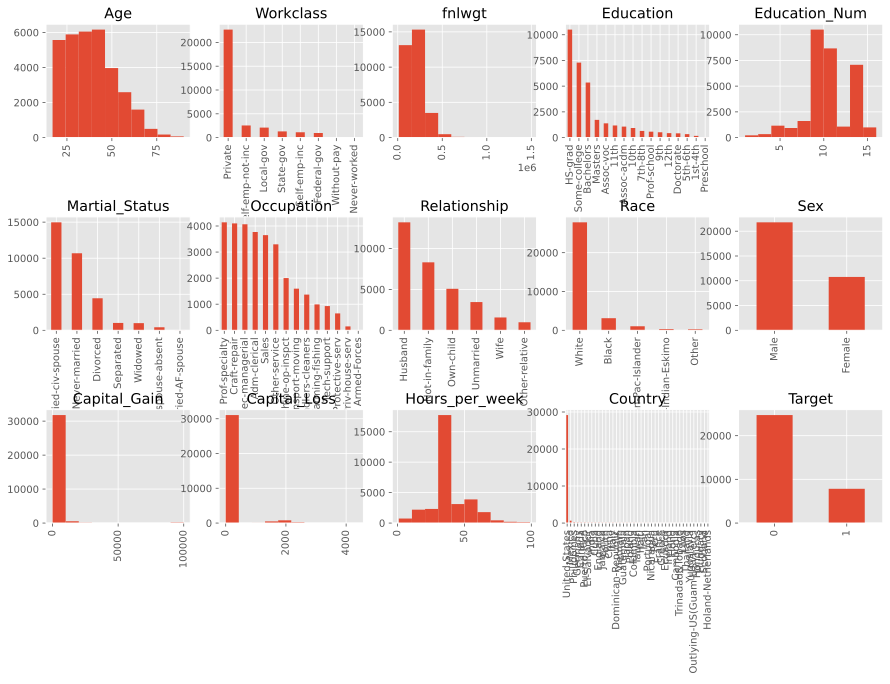

In [20]:
fig = plt.figure(figsize=(15, 9))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)


Перевіряємо типи даних.

In [21]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [22]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

З'ясувалося, що в тестовому наборі даних вік віднесений до типу object, необхідно це виправити.

In [23]:
data_test['Age'] = data_test['Age'].astype(int)

Також переведемо показники типу float в int для відповідності train і test вибірок.

In [24]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

Заповнимо пропуски в кількісних полях значеннями [медіан](https://uk.wikipedia.org/wiki/%D0%9C%D0%B5%D0%B4%D1%96%D0%B0%D0%BD%D0%B0_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0)), а в категоріальних - ті значення, що зустрічаються найчастіше ([мода](https://uk.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B0_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0))).

In [25]:
# виділимо у вибірках категоріальні і числові поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [26]:
# заповнюємо пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

Кодуємо категоріальні ознаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Це можна зробити за допомогою методу `pandas get_dummies`.

In [27]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [28]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [29]:
data_test.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,16281.0,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...
Country_ Thailand,16281.0,0.000737,0.027140,0.0,0.0,0.0,0.0,1.0
Country_ Trinadad&Tobago,16281.0,0.000491,0.022162,0.0,0.0,0.0,0.0,1.0
Country_ United-States,16281.0,0.900559,0.299262,0.0,1.0,1.0,1.0,1.0
Country_ Vietnam,16281.0,0.001167,0.034143,0.0,0.0,0.0,0.0,1.0


In [30]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [31]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

У тестовій вибірці не виявилося Нідерландів. Заведемо необхідну ознаку та заповнимо рядки нулями.

In [32]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [33]:
set(data_train.columns) - set(data_test.columns)

set()

In [34]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [35]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0


In [36]:
# Переназначимо цільову ознаку 'Target'
# як окремий список міток для навчального та тестового наборів даних
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

# Подамо навчальні та тестові дані у вигляді матриць `dtype=np.float32`
X_train = X_train.values
X_test = X_test.values

<a class="anchor" id="3.3.1"></a>

### <span style="color:blue; font-size:1em;">3.3.1. Модель дерева рішень без налаштування параметрів</span>

[Повернутися до змісту](#3)

<span style="color:red; font-size:2em;">Завдання 3</span>

---

**Для всіх варіантів:**

Виконайте навчання дерева рішень з максимальною глибиною 3 за наявною навчальною вибіркою. Оцініть якість побудованої моделі дерева рішень за тестовою вибіркою. Використайте параметр `random_state=17` для відтворюваності результатів. Зробіть прогноз за тестовою вибірки на основі побудованої моделі. Яка частка правильних відповідей (accuracy) дерева рішень за тестовою вибіркою з такими значеннями параметрів?

---

**Варіант 1:** Виконайте навчання дерева рішень із параметрами `max_depth=5`, `min_samples_leaf=4` та `max_features='sqrt'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 2:** Навчіть дерево рішень із параметрами `max_depth=6`, `min_samples_split=6` та `min_samples_leaf=3`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 3:** Виконайте навчання дерева рішень із параметрами `max_depth=2`, `min_samples_split=10`, та `max_features='log2'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 4:** Проведіть навчання дерева рішень із параметрами `max_depth=4`, `min_samples_split=8` та `min_samples_leaf=2`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 5:** Навчіть дерево рішень із параметрами `max_depth=7`, `min_samples_leaf=2` та `max_features='auto'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 6:** Виконайте навчання дерева рішень із параметрами `max_depth=3`, `min_samples_split=12`, та `max_features='sqrt'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 7:** Проведіть навчання дерева рішень із параметрами `max_depth=8`, `min_samples_leaf=3` та `max_features='log2'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 8:** Навчіть дерево рішень із параметрами `max_depth=6`, `min_samples_split=5` та `max_features='auto'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 9:** Виконайте навчання дерева рішень із параметрами `max_depth=9`, `min_samples_leaf=1`, та `max_features='sqrt'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 10:** Проведіть навчання дерева рішень із параметрами `max_depth=10`, `min_samples_split=7` та `max_features='log2'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 11:** Виконайте навчання дерева рішень із параметрами `max_depth=4`, `min_samples_leaf=5` та `max_features='auto'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 12:** Навчіть дерево рішень із параметрами `max_depth=2`, `min_samples_split=10`, та `max_features='sqrt'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 13:** Проведіть навчання дерева рішень із параметрами `max_depth=7`, `min_samples_leaf=3` та `max_features='log2'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 14:** Навчіть дерево рішень із параметрами `max_depth=5`, `min_samples_leaf=4` та `max_features='auto'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 15:** Виконайте навчання дерева рішень із параметрами `max_depth=6`, `min_samples_split=5`, та `max_features='sqrt'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 16:** Використайте параметри `max_depth=8`, `min_samples_split=12`, та `max_features='log2'` для навчання дерева рішень. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 17:** Проведіть навчання дерева рішень із параметрами `max_depth=9`, `min_samples_leaf=3`, та `max_features='auto'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 18:** Навчіть дерево рішень із параметрами `max_depth=4`, `min_samples_split=8`, та `max_features='sqrt'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 19:** Проведіть навчання дерева рішень із параметрами `max_depth=7`, `min_samples_leaf=6`, та `max_features='log2'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

---

**Варіант 20:** Виконайте навчання дерева рішень із параметрами `max_depth=5`, `min_samples_split=8`, та `max_features='auto'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі дерева рішень за тестовим набором даних.

<a class="anchor" id="3.3.2"></a>

### <span style="color:blue; font-size:1em;">3.3.2. Модель найближчих сусідів без налаштування параметрів</span>

[Повернутися до змісту](#3)

<span style="color:red; font-size:2em;">Завдання 4</span>

---

**Для всіх варіантів:**

Виконайте навчання моделі найближчих сусідів із кількістю сусідів 1 за наявною навчальною вибіркою. Оцініть якість побудованої моделі за тестовою вибіркою. Використайте параметри `leaf_size=10` для додаткового налаштування моделі. Зробіть прогноз за тестовою вибіркою на основі побудованої моделі. Яка частка правильних відповідей (accuracy) моделі найближчих сусідів за тестовою вибіркою з такими значеннями параметрів?

---

**Варіант 1:** Виконайте навчання моделі найближчих сусідів із параметрами `n_neighbors=5`, `weights='uniform'`, та `p=1`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової (базової) моделі найближчих сусідів за тестовим набором даних.

---

**Варіант 2:** Навчіть модель найближчих сусідів із параметрами `n_neighbors=7`, `weights='distance'`, та `p=2`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі найближчих сусідів за тестовим набором даних.

---

**Варіант 3:** Виконайте навчання моделі найближчих сусідів із параметрами `n_neighbors=10`, `weights='uniform'`, та `p=1`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

---

**Варіант 4:** Проведіть навчання моделі найближчих сусідів із параметрами `n_neighbors=3`, `weights='distance'`, та `algorithm='ball_tree'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 5:** Навчіть модель найближчих сусідів із параметрами `n_neighbors=8`, `weights='uniform'`, та `algorithm='kd_tree'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

---

**Варіант 6:** Виконайте навчання моделі найближчих сусідів із параметрами `n_neighbors=12`, `weights='distance'`, та `leaf_size=30`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 7:** Проведіть навчання моделі найближчих сусідів із параметрами `n_neighbors=6`, `weights='uniform'`, та `leaf_size=40`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

---

**Варіант 8:** Навчіть модель найближчих сусідів із параметрами `n_neighbors=9`, `weights='distance'`, та `algorithm='brute'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 9:** Виконайте навчання моделі найближчих сусідів із параметрами `n_neighbors=11`, `weights='uniform'`, та `p=2`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

---

**Варіант 10:** Проведіть навчання моделі найближчих сусідів із параметрами `n_neighbors=4`, `weights='distance'`, та `algorithm='ball_tree'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 11:** Навчіть модель найближчих сусідів із параметрами `n_neighbors=7`, `weights='uniform'`, та `leaf_size=50`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 12:** Виконайте навчання моделі найближчих сусідів із параметрами `n_neighbors=6`, `weights='distance'`, та `p=1`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

---

**Варіант 13:** Проведіть навчання моделі найближчих сусідів із параметрами `n_neighbors=10`, `weights='uniform'`, та `algorithm='kd_tree'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 14:** Навчіть модель найближчих сусідів із параметрами `n_neighbors=15`, `weights='distance'`, та `p=2`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

---

**Варіант 15:** Виконайте навчання моделі найближчих сусідів із параметрами `n_neighbors=5`, `weights='uniform'`, та `leaf_size=60`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 16:** Проведіть навчання моделі найближчих сусідів із параметрами `n_neighbors=8`, `weights='distance'`, та `algorithm='brute'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

---

**Варіант 17:** Навчіть модель найближчих сусідів із параметрами `n_neighbors=13`, `weights='uniform'`, та `p=1`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 18:** Виконайте навчання моделі найближчих сусідів із параметрами `n_neighbors=9`, `weights='distance'`, та `leaf_size=70`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

---

**Варіант 19:** Проведіть навчання моделі найближчих сусідів із параметрами `n_neighbors=14`, `weights='uniform'`, та `algorithm='ball_tree'`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти початкової моделі за тестовим набором даних.

---

**Варіант 20:** Навчіть модель найближчих сусідів із параметрами `n_neighbors=6`, `weights='distance'`, та `p=2`. Оцініть, як зміна параметрів впливає на частку правильних відповідей (accuracy) проти базової моделі за тестовим набором даних.

<a class="anchor" id="3.3.3"></a>

### <span style="color:blue; font-size:1em;">3.3.3. Машинне моделювання з налаштуванням параметрів</span>

[Повернутися до змісту](#3)

<span style="color:red; font-size:2em;">Завдання 5</span>

---

**Варіант 1:** Виконайте навчання моделей дерева рішень та найближчих сусідів із використанням `GridSearchCV` та 5-кратної крос-валідації. Для дерева рішень використайте параметри: `max_depth=[3, 5, 7]`, `min_samples_split=[2, 5]`, а для моделі найближчих сусідів: `n_neighbors=[3, 5, 7]`, `weights=['uniform', 'distance']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 2:** Виконайте навчання моделей дерева рішень та найближчих сусідів із використанням `GridSearchCV` та 5-кратної крос-валідації. Для дерева рішень використайте параметри: `max_depth=[4, 6, 8]`, `min_samples_leaf=[1, 2, 4]`, а для моделі найближчих сусідів: `n_neighbors=[4, 6, 8]`, `algorithm=['auto', 'ball_tree']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 3:** Застосуйте `GridSearchCV` із 5-кратною крос-валідацією для моделей дерева рішень та найближчих сусідів. Для дерева рішень використайте параметри: `max_depth=[2, 5]`, `min_samples_split=[2, 4, 6]`, а для моделі найближчих сусідів: `n_neighbors=[5, 7, 9]`, `weights=['uniform']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 4:** Навчіть моделі з використанням `GridSearchCV` та 5-кратної крос-валідації. Для дерева рішень варіативність у параметрах: `max_depth=[3, 6]`, `min_samples_leaf=[2, 5]`, а для найближчих сусідів: `n_neighbors=[3, 6, 9]`, `algorithm=['kd_tree', 'brute']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 5:** Виконайте навчання моделей за допомогою `GridSearchCV` із 5-кратною крос-валідацією. Для дерева рішень використайте: `max_depth=[4, 8]`, `min_samples_split=[4, 6]`, а для найближчих сусідів: `n_neighbors=[4, 6, 8]`, `leaf_size=[30, 50]`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 6:** Застосуйте 5-кратну крос-валідацію в `GridSearchCV` для дерева рішень із параметрами: `max_depth=[3, 5, 7]`, `min_samples_leaf=[3, 5]`, та для найближчих сусідів: `n_neighbors=[5, 10, 15]`, `weights=['distance']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 7:** Використайте `GridSearchCV` із 5-кратною крос-валідацією. Параметри для дерева рішень: `max_depth=[6, 9]`, `min_samples_split=[3, 5]`, для найближчих сусідів: `n_neighbors=[7, 10, 12]`, `algorithm=['auto', 'ball_tree']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 8:** Здійсніть навчання з використанням `GridSearchCV` та 5-кратної крос-валідації для дерева рішень із параметрами: `max_depth=[5, 8]`, `min_samples_leaf=[1, 3]`, для моделі найближчих сусідів: `n_neighbors=[3, 5, 8]`, `weights=['uniform', 'distance']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 9:** Застосуйте 5-кратну крос-валідацію в `GridSearchCV`. Параметри для дерева рішень: `max_depth=[4, 6]`, `min_samples_split=[2, 4]`, для найближчих сусідів: `n_neighbors=[6, 9]`, `leaf_size=[20, 40]`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 10:** Навчіть моделі із `GridSearchCV` та 5-кратною крос-валідацією. Для дерева рішень використайте: `max_depth=[7, 10]`, `min_samples_leaf=[3, 4]`, а для найближчих сусідів: `n_neighbors=[4, 8, 12]`, `algorithm=['kd_tree']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 11:** Виконайте навчання із `GridSearchCV` та 5-кратною крос-валідацією для дерева рішень: `max_depth=[3, 6]`, `min_samples_split=[4, 6]`, та найближчих сусідів: `n_neighbors=[7, 10]`, `weights=['distance']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 12:** Використайте `GridSearchCV` та 5-кратну крос-валідацію для дерева рішень із параметрами: `max_depth=[2, 4]`, `min_samples_leaf=[2, 3]`, та найближчих сусідів: `n_neighbors=[5, 9]`, `p=[1, 2]`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

**Варіант 13:** Застосуйте 5-кратну крос-валідацію в `GridSearchCV`. Для дерева рішень: `max_depth=[4, 8]`, `min_samples_split=[3, 5]`, а для найближчих сусідів: `n_neighbors=[6, 10]`, `weights=['uniform', 'distance']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 14:** Використайте `GridSearchCV` із 5-кратною крос-валідацією для дерева рішень із параметрами: `max_depth=[6, 9]`, `min_samples_leaf=[2, 5]`, та найближчих сусідів: `n_neighbors=[8, 12]`, `algorithm=['brute']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 15:** Навчіть моделі із 5-кратною крос-валідацією за допомогою `GridSearchCV`. Для дерева рішень використайте: `max_depth=[5, 7]`, `min_samples_split=[2, 6]`, для найближчих сусідів: `n_neighbors=[5, 9]`, `p=[1, 2]`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 16:** Застосуйте `GridSearchCV` із 5-кратною крос-валідацією. Для дерева рішень: `max_depth=[3, 6]`, `min_samples_leaf=[4, 5]`, для найближчих сусідів: `n_neighbors=[3, 6]`, `algorithm=['kd_tree']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 17:** Виконайте навчання за допомогою `GridSearchCV` та 5-кратної крос-валідації для дерева рішень: `max_depth=[6, 10]`, `min_samples_split=[3, 4]`, та найближчих сусідів: `n_neighbors=[5, 10]`, `weights=['uniform', 'distance']`.Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 18:** Застосуйте 5-кратну крос-валідацію в `GridSearchCV` для дерева рішень із параметрами: `max_depth=[4, 6]`, `min_samples_leaf=[3, 5]`, для моделі найближчих сусідів: `n_neighbors=[4, 8]`, `algorithm=['brute']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 19:** Навчіть моделі із 5-кратною крос-валідацією в `GridSearchCV`. Для дерева рішень використайте: `max_depth=[2, 5]`, `min_samples_split=[2, 3]`, а для найближчих сусідів: `n_neighbors=[6, 9]`, `leaf_size=[20, 40]`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.

---

**Варіант 20:** Застосуйте `GridSearchCV` та 5-кратну крос-валідацію для дерева рішень із параметрами: `max_depth=[5, 9]`, `min_samples_leaf=[2, 3]`, та найближчих сусідів: `n_neighbors=[3, 6, 9]`, `weights=['uniform']`. Налаштуйте обидві моделі так, щоб **досягти частки правильних відповідей ≥90 %.** Оцініть, як автоматично налаштовані значення параметрів впливають на частку правильних відповідей (accuracy) проти початкових (базових) моделей дерева рішень (Завдання 3) та найближчих сусідів (Завдання 4) за тестовим набором даних.